# Predicting house prices using k-nearest neighbors regression

In [13]:
import graphlab
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load in house sales data

In [14]:
# Housing sales data for King County, Seatle, WA
sales = graphlab.SFrame('kc_house_data_small.gl/')

In [15]:
def get_numpy_data(df,features,output):
    df['constant']=1 # A new column for the constant/intercept term
    features=['constant']+features # Column Names
    sframe=df[features] # Copy all the data for the selected features in the new dataframe
    smatrix=sframe.to_numpy() # Creating a numpy array for the features
    output_array=np.array(df[output])# Array for the ouptut/target
    return smatrix, output_array

We will also need the `normalize_features()` function from Week 5 that normalizes all feature columns to unit norm. Paste this function below.

In [16]:
def normalize_features(features):
    #To normalize the dataset
    norms = np.linalg.norm(features, axis=0)
    normalized_features=features/norms
    return (normalized_features, norms)

# Split data into training, test, and validation sets

In [17]:
(train_and_validation, test) = sales.random_split(.8, seed=1) # initial train/test split
(train, validation) = train_and_validation.random_split(.8, seed=1) # split training set into training and validation sets

# Extract features and normalize

In [18]:
feature_list = ['bedrooms',  
                'bathrooms',  
                'sqft_living',  
                'sqft_lot',  
                'floors',
                'waterfront',  
                'view',  
                'condition',  
                'grade',  
                'sqft_above',  
                'sqft_basement',
                'yr_built',  
                'yr_renovated',  
                'lat',  
                'long',  
                'sqft_living15',  
                'sqft_lot15']
# Get the features in array for the test,training and validation data
features_train, output_train = get_numpy_data(train, feature_list, 'price')
features_test, output_test = get_numpy_data(test, feature_list, 'price')
features_valid, output_valid = get_numpy_data(validation, feature_list, 'price')

In [19]:
features_train, norms = normalize_features(features_train) # normalize training set features (columns)
features_test = features_test / norms # normalize test set by training set norms
features_valid = features_valid / norms # normalize validation set by training set norms

# Compute a single distance

We will take our **query house** to be the first house of the test set and look at the distance between this house and the 10th house of the training set.

In [20]:
#Set query house as house 0
query=features_test[0]

#House 10
house10=features_train[9]
house10

array([ 0.01345102,  0.01163464,  0.00602491,  0.0083488 ,  0.00050756,
        0.01279425,  0.        ,  0.        ,  0.01938684,  0.01390535,
        0.0096309 ,  0.        ,  0.01302544,  0.        ,  0.01346821,
       -0.01346254,  0.01195898,  0.00156612])

In [21]:
#Euclidean distance between the query house and the 10th house
print "The Euclidean distance between the query house and House 10 is",(np.sqrt(np.sum((query-house10)**2)))

The Euclidean distance between the query house and House 10 is 0.0597235937167


# Compute multiple distances

Of course, to do nearest neighbor regression, we need to compute the distance between our query house and *all* houses in the training set.  

To visualize this nearest-neighbor search, let's first compute the distance from our query house (`features_test[0]`) to the first 10 houses of the training set (`features_train[0:10]`) and then search for the nearest neighbor within this small set of houses.  Through restricting ourselves to a small set of houses to begin with, we can visually scan the list of 10 distances to verify that our code for finding the nearest neighbor is working.

Write a loop to compute the Euclidean distance from the query house to each of the first 10 houses in the training set.

In [22]:
#Initial closet house is 10
a,index=1,1

# To calculate the distance of first 10 houses from the training set to house 0 from test data
for i in range(len(features_train[0:10])):
    dist=np.sqrt(np.sum((query-features_train[i])**2))
    if dist<a:
        a=dist
        index=i+1
    print "House",(i+1),"is at an Euclidean distance of",(dist),"from House 0 of test set\n"
print("Closet House is %d and the distance is %f" %(index,a))

House 1 is at an Euclidean distance of 0.060274709173 from House 0 of test set

House 2 is at an Euclidean distance of 0.0854688114883 from House 0 of test set

House 3 is at an Euclidean distance of 0.0614994643712 from House 0 of test set

House 4 is at an Euclidean distance of 0.0534027397882 from House 0 of test set

House 5 is at an Euclidean distance of 0.0584448406394 from House 0 of test set

House 6 is at an Euclidean distance of 0.0598792151018 from House 0 of test set

House 7 is at an Euclidean distance of 0.0546314049726 from House 0 of test set

House 8 is at an Euclidean distance of 0.0554310832416 from House 0 of test set

House 9 is at an Euclidean distance of 0.052383627841 from House 0 of test set

House 10 is at an Euclidean distance of 0.0597235937167 from House 0 of test set

Closet House is 9 and the distance is 0.052384


It is computationally inefficient to loop over computing distances to all houses in our training dataset. Fortunately, many of the Numpy functions can be **vectorized**, applying the same operation over multiple values or vectors.  We now walk through this process.

# Perform 1-nearest neighbor regression

In [23]:
#Calculate the difference between all the training data and the query house
diff=features_train[0:len(features_train)]-features_test[0]

The next step in computing the Euclidean distances is to take these feature-by-feature differences in `diff`, square each, and take the sum over feature indices.  That is, compute the sum of square feature differences for each training house (row in `diff`).

In [24]:
#Calculating the distances
distances=np.sqrt(np.sum(diff**2,axis=1))

Below is  a function that computes the distances from a query house to all training houses. The function takes two parameters: (i) the matrix of training features and (ii) the single feature vector associated with the query.

In [25]:

def comp_distances(features_instances, features_query):
    #FUnction that computes the distance between the query house and training set
    diff = features_instances[0:len(features_instances)] - features_query
    distances = np.sqrt(np.sum(diff**2, axis=1))
    return distances


distances = comp_distances(features_train, features_test[2])
min = distances[0]
index = 0

#To find the house closet to the query house
for i in xrange(len(distances)):
    if(distances[i] < min):
        min = distances[i]
        index = i
print "The closet house to query house is at index",index,"and the distance is",min

The closet house to query house is at index 382 and the distance is 0.00286049526751


In [26]:
#Fucntion to calculate the distance form to a house
def dist_from_to(fe_m,query_matrix):
    d_d=fe_m[0:len(fe_m)]-query_matrix
    d_q=np.sqrt(np.sum(d_d**2,axis=1))
    return d_q

# Perform k-nearest neighbor regression

For k-nearest neighbors, we need to find a *set* of k houses in the training set closest to a given query house. We then make predictions based on these k nearest neighbors.

In [27]:
# Fucntion to calculate the k closet house to the query house
def dist_from_to_k(feature_matrix,query_matrix,k):
    di=feature_matrix[:]-query_matrix
    distances_query=np.sqrt(np.sum(di**2,axis=1))
    index_closet=np.argsort(distances)[0:k]
    return index_closet


*** QUIZ QUESTION ***

Take the query house to be third house of the test set (`features_test[2]`).  What are the indices of the 4 training houses closest to the query house?

In [28]:
#which are the four Training house closet to test house[2]
q3=dist_from_to_k(features_train,features_test[2],4)
q3

array([ 382, 1149, 4087, 3142], dtype=int64)

## Make a single prediction by averaging k nearest neighbor outputs

Now that we know how to find the k-nearest neighbors, write a function that predicts the value of a given query house. **For simplicity, take the average of the prices of the k nearest neighbors in the training set**. The function should have the following parameters:
 * the value of k;
 * the feature matrix for the training houses;
 * the output values (prices) of the training houses; and
 * the feature vector of the query house, whose price we are predicting.
 
The function should return a predicted value of the query house.

**Hint**: You can extract multiple items from a Numpy array using a list of indices. For instance, `output_train[[6, 10]]` returns the prices of the 7th and 11th training houses.

In [29]:
#Calculate the value of the house based on the k-nearest neighbors
def predict_value(k,feature_matrix,output_values,query_house):
    difference=feature_matrix-query_house
    distances_query=np.sqrt(np.sum(difference**2,axis=1))
    index_closet=np.argsort(distances)[0:k]
    avg_price=np.sum(output_values[index_closet[:]])
    avg_price=avg_price/float(len(index_closet))
    return avg_price

*** QUIZ QUESTION ***

Again taking the query house to be third house of the test set (`features_test[2]`), predict the value of the query house using k-nearest neighbors with `k=4` and the simple averaging method described and implemented above.

In [30]:
# Predicted value of house 3 in test data, using k=4
a=predict_value(4,features_train,output_train,features_test[4])
print "Predicted value of house 3 from test data based on k-nearest negihbors where k=4 is",('%3f' %a)
print "The actual value of the house is",output_test[2]

Predicted value of house 3 from test data based on k-nearest negihbors where k=4 is 413987.500000
The actual value of the house is 438000


There remains a question of choosing the value of k to use in making predictions. Here, we use a validation set to choose this value. Write a loop that does the following:

* For `k` in [1, 2, ..., 15]:
    * Makes predictions for each house in the VALIDATION set using the k-nearest neighbors from the TRAINING set.
    * Computes the RSS for these predictions on the VALIDATION set
    * Stores the RSS computed above in `rss_all`

In [41]:
rss_all = np.zeros(15)
for k in range(1,16):
    predictions_k = predict_value(k, features_train, output_train, features_test[0])
    rss_all[k-1] = np.sum((predictions_k-output_valid)**2)
    print k,rss_all[k-1]

1 3.1308142995e+14
2 2.3347267407e+14
3 2.12052567884e+14
4 2.09938610404e+14
5 2.24220698554e+14
6 2.11115066113e+14
7 2.14683075375e+14
8 2.18055258692e+14
9 2.02742345974e+14
10 1.94953528616e+14
11 1.95912790578e+14
12 1.94864370876e+14
13 1.9328447847e+14
14 1.93879594861e+14
15 1.94418081214e+14


To visualize the performance as a function of `k`, plot the RSS on the VALIDATION set for each considered `k` value:

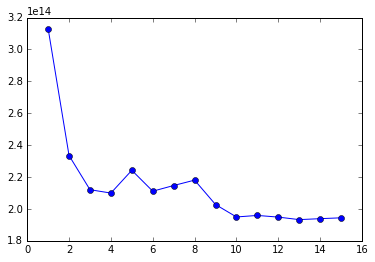

In [42]:
kvals = range(1, 16)
plt.plot(kvals, rss_all,'bo-')

## Thank you!